In [2]:
# Dependencies
import os
import pickle
import string
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu
from matplotlib import pyplot as plt

import torch 
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import transforms, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

In [4]:
# Import saved data

file_root = "../data/task1/flickr/"
save_root = "../saved_data/image_captioning/rnn/"

objects = {}
object_names = ["train_features", "train_captions", "test_features", "test_captions",
                "tokenizer"]

for name in object_names:
    with open(save_root + name + ".pkl", "rb") as f:
        obj = pickle.load(f)
        objects.update({name: obj})

# Helper functions

In [14]:
def get_embedding_weights(file_path):
    """ Loads glove embeddings from a file and
    generates embedding matrix for embedding layer"""

    with open(file_path, "r") as f:
        lines = f.read().split("\n")

    embedding_map = {}
    # Extract word and vector from every line and ...
    # ... store it in a dictionary
    for line in tqdm(lines):
        try:
            word, vec = line.split()[0], \
                np.array(line.split()[1:]).astype("float")
        except:
            continue

        embedding_map[word] = vec

    embedding_matrix = np.random.uniform(0, 1, (vocab_size, embedding_dim))
    tokenizer_vocab = np.array(list(tokenizer.word_index.keys()))

    for word in tokenizer_vocab:
        if word in embedding_map.keys():
            idx = np.where(word == tokenizer_vocab)[0]
            embedding_matrix[idx] = embedding_map[word]

    return torch.FloatTensor(embedding_matrix)

# Model definition

In [15]:
class Network(torch.nn.Module):

    def __init__(self, depth, embedding_dim, glove_weights):
        super(Network, self).__init__()

        self.fc_1 = torch.nn.Linear(4096, depth)
        self.fc_2 = torch.nn.Linear(depth, depth)
        self.fc_3 = torch.nn.Linear(depth, vocab_size)
        self.dropout_1 = torch.nn.Dropout(0.5)
        self.dropout_2 = torch.nn.Dropout(0.5)
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, depth, batch_first=True)

        # Initialize embedding weights to GloVe
        self.embedding.weight = torch.nn.Parameter(glove_weights)


    def forward(self, img_in, caption_in):
        
        x1 = self.dropout_1(img_in)         # (batch_size, 4096)
        x1 = self.fc_1(img_in)              # (batch_size, depth)
        x1 = F.relu(x1)

        x2 = self.embedding(caption_in)     # (batch_size, max_length, embedding_dim)
        x2 = self.dropout_2(x2)             # (batch_size, max_length, embedding_dim)
        x2, _ = self.rnn(x2)                # (batch_size, depth)
        x2 = x2[:, -1, :]                   # Pick only the last sequence output

        x3 = self.fc_2(x1 + x2)             # (batch_size, depth)
        x3 = F.relu(x3)
        out = self.fc_3(x3)                 # (batch_size, vocab_size)
        out = F.log_softmax(out, dim=-1)

        return out

# Evaluation functions

In [25]:
def generate_caption(img_fs):
    in_text = 'startseq'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        pred = model(torch.FloatTensor(img_fs), torch.LongTensor(seq))
        pred_idx = pred.argmax(dim=-1).detach().numpy()[0]
        word = tokenizer.index_word.get(pred_idx)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'endseq':
            break
            
    final = [w for w in in_text.split() if w not in ['startseq', 'endseq']]
    return ' '.join(final)


def display_predictions(img_features, img_dir, num_samples=5):
    idx = np.random.choice(np.arange(0, len(img_features)), size=num_samples, replace=False)
    names = np.array(list(img_features.keys()))[idx]
    paths = [img_dir + name for name in names]
    
    for name, path in zip(names, paths):
        caption = generate_caption(img_features[name])
        img = plt.imread(path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print("[CAPTION] {}".format(caption))
        print('\n-------------------------------------------------------\n')


def evaluate_model(model, descriptions, img_features):
    actual, predicted = [], []
    for key, desc_list in tqdm(descriptions.items()):
        hyp = generate_caption(img_features[key])
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(hyp.split())
    
    print("BLEU-1: {:.3f}".format(corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))))
    print("BLEU-2: {:.3f}".format(corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))))
    print("BLEU-3: {:.3f}".format(corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))))
    print("BLEU-4: {:.3f}".format(corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))))

# Evaluate model

In [51]:
# Constants
max_length = 34
depth = 256
embedding_dim = 200
tokenizer = objects["tokenizer"]
vocab_size = len(tokenizer.word_index) + 1

# Load glove weights
embedding_weights = get_embedding_weights("../glove/glove.6B/glove.6B.200d.txt")

# Load model
model_path = save_root + "models/model_100"
model = Network(depth=256, embedding_dim=200, glove_weights=embedding_weights)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Training data evaluation
print("\n[INFO] Train data evaluation...\n")
evaluate_model(model, objects["train_captions"], objects["train_features"])

print("\n")

# Test data evaluation
print("\n[INFO] Test data evaluation...\n")
evaluate_model(model, objects["test_captions"], objects["test_features"])



[INFO] Train data evaluation...




BLEU-1: 0.358
BLEU-2: 0.178
BLEU-3: 0.125
BLEU-4: 0.067



[INFO] Test data evaluation...




BLEU-1: 0.349
BLEU-2: 0.159
BLEU-3: 0.090
BLEU-4: 0.028


# Examples

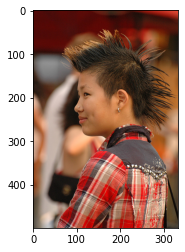

[CAPTION] man is riding in red jacket wearing red jacket

-------------------------------------------------------



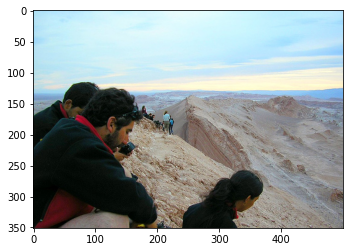

[CAPTION] man is running on rock that in front of blue is is in the distance

-------------------------------------------------------



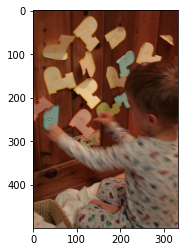

[CAPTION] man is running on the sand in the snow

-------------------------------------------------------



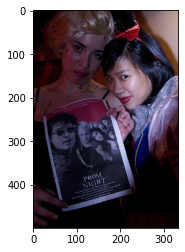

[CAPTION] man is riding in front of the girl is in the ground

-------------------------------------------------------



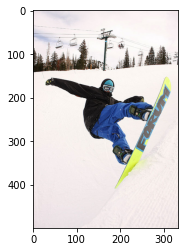

[CAPTION] man in red jacket is walking on the sand

-------------------------------------------------------



In [45]:
# Show five examples

img_dir = file_root + "flickr_images/"
display_predictions(objects["train_features"], img_dir, num_samples=5)